## **Cámaras Galería de arte**


En una galería de arte cuyo plano es el de la figura, se desean instalar cámaras de video para tenerla completamente vigilada. Hay 9 zonas A, B, . . . , I, y 9 posibles puntos 1, . . . , 9 de instalación de las cámaras. Una cámara colocada en cualquiera de los puntos señalados vigila todas las zonas adyacentes a dicho punto. Por ejemplo, una cámara en el punto 3 vigila las zonas A y B y una cámara en el punto 8 vigila las zonas B, F, G y C. Todas la zonas deben está vigilidas por al menos una cámara.



Por requerimientos tecnológicos, si se sitúan cámaras en los puntos 2,3 y 4, estas cámaras costarían $5, $7 y $8. Para los otros puntos, una cámara de valor de $2 cumpliría con los requerimientos.

Se tienen los siguientes requerimientos

1. El número de cámaras que vigilan G debe ser mayor al número de cámaras que vigilan B
2. Si se instala una cámara en 6 y no se instala cámara en 3 entonces se debe instalar una cámara en 9
3. No se puede tener más que 3 cámaras que vigilan el sector constituido por las zonas A y B

La transmisión de los datos entre cámaras se hace mediante una red wifi. Los datos de grabación llegan a un router wifi común. La galería quiere saber dónde instalar el router y las cámaras teniendo en cuenta que:

-   El router wifi solo se puede instalar en uno de los 9 puntos de instalación de cámaras.
-   El router wifi no se puede instalar en un punto donde hay una cámara.
-   Cada cámara se conecta directamente al router wifi. El nivel de radiaciones que genera la conexión es proporcional a la distancia entre la cámara y el router y vale 15 unidades de radiación/metro. Las distancias entre los puntos se muestran en la tabla siguiente.

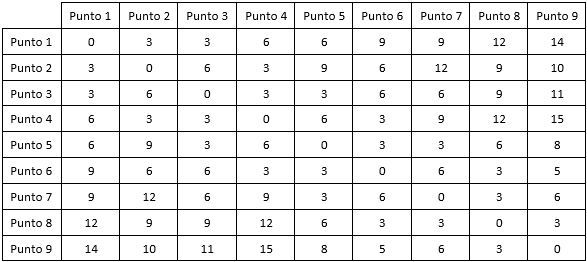

Formula el correspondiente modelo en programación lineal en FORMA COMPACTA para determinar dónde se deben instalar las cámaras de manera que se minimice el costo total de instalación de cámaras y la suma total de las radiaciones generadas por las conexiones entre cada cámara y el router wifi.


In [3]:
import pandas
import gurobipy as gp
from gurobipy import GRB
import networkx as nx
import plotly.graph_objects as go
import plotly.subplots

In [4]:
df_punto_zona = pandas.read_excel("./data.xlsx", sheet_name="Punto Zona", index_col=0)
df_costo_instalacion = pandas.read_excel("./data.xlsx", sheet_name="Costo Instalación")
df_distancias = pandas.read_excel("./data.xlsx", sheet_name="Distancias", index_col=0)

**Conjuntos**


$$ P: \text{Puntos} = \{1, 2, 3, 4, 5, 6, 7, 8, 9\}$$
$$ Z: \text{Zonas} = \{\text{A, B, C, D, E, F, G, H, I}\} $$

In [5]:
PUNTOS = df_punto_zona.index.to_list()
ZONAS = df_punto_zona.columns.to_list()

**Parámetros**


$$ \alpha_{p,z} = \left\{ \begin{array}{cl}
1:\text{Si la camara del punto } p\in P \text{ vigila la zona } z\in Z \\
0:\text{dlc}
\end{array} \right. $$
$$ \text{Costo\_Instalacion}_{p}: \text{Costo de instalar una cámara en un punto } p\in P $$
$$ \text{Distancia}_{p1,p2}: \text{Distancia en metros de un punto } p1\in P \text{ a un punto } p2\in P $$

In [6]:
COSTO_INSTALACION = df_costo_instalacion.set_index("Punto")["Costo Instalación"].to_dict()
ALPHA = df_punto_zona.to_dict("index")
DISTANCIA = df_distancias.to_dict("index")

In [7]:
model1 = gp.Model()

## Variables
x1 = model1.addVars(PUNTOS, vtype=GRB.BINARY, name="x1")
y1 = model1.addVars(ZONAS, vtype=GRB.INTEGER, name="y1")
w1 = model1.addVars(PUNTOS, vtype=GRB.BINARY, name="w1")

## Función Objetivo
costo_instalacion_camara = gp.quicksum(COSTO_INSTALACION[punto] * x1[punto] for punto in PUNTOS)
radiacion_wifi = gp.quicksum(15 * DISTANCIA[punto1][punto2] * w1[punto1] for punto1 in PUNTOS for punto2 in PUNTOS)
model1.setObjectiveN(costo_instalacion_camara, index=0, priority=1, weight=1)
model1.setObjectiveN(radiacion_wifi, index=1, priority=2, weight=1)
model1.ModelSense = GRB.MINIMIZE

## Restricciones
for zona in ZONAS:
    model1.addConstr(y1[zona] == gp.quicksum(ALPHA[punto][zona] * x1[punto] for punto in PUNTOS))

for zona in ZONAS:
    model1.addConstr(y1[zona] >= 1)

model1.addConstr(y1["B"] >= y1["G"] - 1)
model1.addConstr(x1[9] >= x1[6] + (1 - x1[3]) - 1)
model1.addConstr(x1[1] + x1[2] + x1[3] + x1[8] <= 3)

model1.addConstr(gp.quicksum(w1[punto] for punto in PUNTOS) == 1)

for punto in PUNTOS:
    model1.addConstr(w1[punto] <= 1 - x1[punto])

## Optimizar
model1.optimize()

Set parameter Username
Academic license - for non-commercial use only - expires 2025-01-28
Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 31 rows, 27 columns and 75 nonzeros
Model fingerprint: 0x9b087489
Variable types: 0 continuous, 27 integer (18 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 15

In [8]:
model2 = gp.Model()

## Variables
x2 = model2.addVars(PUNTOS, vtype=GRB.BINARY, name="x2")
y2 = model2.addVars(ZONAS, vtype=GRB.INTEGER, name="y2")
w2 = model2.addVars(PUNTOS, vtype=GRB.BINARY, name="w2")

## Función Objetivo
costo_instalacion_camara = gp.quicksum(COSTO_INSTALACION[punto] * x2[punto] for punto in PUNTOS)
radiacion_wifi = gp.quicksum(15 * DISTANCIA[punto1][punto2] * w2[punto1] for punto1 in PUNTOS for punto2 in PUNTOS)
model2.setObjectiveN(costo_instalacion_camara, index=0, priority=2, weight=1)
model2.setObjectiveN(radiacion_wifi, index=1, priority=1, weight=1)
model2.ModelSense = GRB.MINIMIZE

## Restricciones
for zona in ZONAS:
    model2.addConstr(y2[zona] == gp.quicksum(ALPHA[punto][zona] * x2[punto] for punto in PUNTOS))
    # model2.addConstr(y2[zona] == gp.quicksum(ALPHA_ALT[punto, zona] * x2[punto] for punto in PUNTOS))

for zona in ZONAS:
    model2.addConstr(y2[zona] >= 1)

model2.addConstr(y2["B"] >= y2["G"] - 1)
model2.addConstr(x2[9] >= x2[6] + (1 - x2[3]) - 1)
model2.addConstr(x2[1] + x2[2] + x2[3] + x2[8] <= 3)

model2.addConstr(gp.quicksum(w2[punto] for punto in PUNTOS) == 1)

for punto in PUNTOS:
    model2.addConstr(w2[punto] <= 1 - x2[punto])

## Optimizar
model2.optimize()

Gurobi Optimizer version 11.0.1 build v11.0.1rc0 (win64 - Windows 11.0 (22631.2))

CPU model: Intel(R) Core(TM) i7-9750H CPU @ 2.60GHz, instruction set [SSE2|AVX|AVX2]
Thread count: 6 physical cores, 12 logical processors, using up to 12 threads

Optimize a model with 31 rows, 27 columns and 75 nonzeros
Model fingerprint: 0xbef1cd56
Variable types: 0 continuous, 27 integer (18 binary)
Coefficient statistics:
  Matrix range     [1e+00, 1e+00]
  Objective range  [2e+00, 1e+03]
  Bounds range     [1e+00, 1e+00]
  RHS range        [1e+00, 3e+00]

---------------------------------------------------------------------------
Multi-objectives: starting optimization with 2 objectives ... 
---------------------------------------------------------------------------

Multi-objectives: applying initial presolve ...
---------------------------------------------------------------------------

Presolve removed 15 rows and 7 columns
Presolve time: 0.00s
Presolved: 16 rows, 20 columns, 49 nonzeros
------

In [9]:
# Definiendo Grafo
G = nx.Graph()

# Añadiendo nodos de cámaras y zonas
G.add_nodes_from(list(map(str, PUNTOS)))
G.add_nodes_from(ZONAS)

# Construyendo aristas
edges = []
for punto, covertura in ALPHA.items():
    for zone, vigila in covertura.items():
        if vigila == 1:
            edges.append((str(punto), zone))

# Añadiendo aristas al grafo
G.add_edges_from(edges)

# Configurando el diseño para la visualización del grafo
pos_alpha = nx.spring_layout(G, seed=43)  # Usando el diseño de resorte (spring layout)

In [10]:
fig = plotly.subplots.make_subplots(
    rows=1,
    cols=2,
    subplot_titles=(
        f"COSTO INSTLACIÓN: {model1.getObjective(0).getValue()} - RADIACIÓN WIFI: {model1.getObjective(1).getValue()}",
        f"COSTO INSTLACIÓN: {model2.getObjective(0).getValue()} - RADIACIÓN WIFI: {model2.getObjective(1).getValue()}",
    ),
)

In [11]:
edge_x = []
edge_y = []
for edge in G.edges():
    coord_x0, coord_y0 = pos_alpha[edge[0]]
    coord_x1, coord_y1 = pos_alpha[edge[1]]
    edge_x.extend([coord_x0, coord_x1, None])
    edge_y.extend([coord_y0, coord_y1, None])

fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode="lines", line=dict(width=2, color="gray"), hoverinfo="none", showlegend=False), row=1, col=1)

# Agregar nodos de ZONAS
for zona in ZONAS:
    coord_x, coord_y = pos_alpha[zona]
    fig.add_trace(go.Scatter(x=[coord_x], y=[coord_y], mode="markers", marker=dict(size=40, color="lightblue"), name="Zonas", text=[zona], hoverinfo="text"), row=1, col=1)

# Agregar nodos de PUNTOS
for punto in PUNTOS:
    coord_x, coord_y = pos_alpha[str(punto)]
    color = "silver"
    if x1[punto].X > 0.9:
        color = "lightgreen"
    if w1[punto].X > 0.9:
        color = "yellow"
    fig.add_trace(go.Scatter(x=[coord_x], y=[coord_y], mode="markers", marker=dict(size=30, color=color, symbol="square"), name="Puntos", text=[str(punto)], hoverinfo="text"), row=1, col=1)

# Agregar etiquetas
for node, (coord_x, coord_y) in pos_alpha.items():
    fig.add_trace(go.Scatter(x=[coord_x], y=[coord_y], mode="text", text=[node], textposition="middle center", hoverinfo="none", showlegend=False), row=1, col=1)

In [12]:
edge_x = []
edge_y = []
for edge in G.edges():
    coord_x0, coord_y0 = pos_alpha[edge[0]]
    coord_x1, coord_y1 = pos_alpha[edge[1]]
    edge_x.extend([coord_x0, coord_x1, None])
    edge_y.extend([coord_y0, coord_y1, None])

fig.add_trace(go.Scatter(x=edge_x, y=edge_y, mode="lines", line=dict(width=2, color="gray"), hoverinfo="none", showlegend=False), row=1, col=2)

# Agregar nodos de ZONAS
for zona in ZONAS:
    coord_x, coord_y = pos_alpha[zona]
    fig.add_trace(go.Scatter(x=[coord_x], y=[coord_y], mode="markers", marker=dict(size=40, color="lightblue"), name="Zonas", text=[zona], hoverinfo="text"), row=1, col=2)

# Agregar nodos de PUNTOS
for punto in PUNTOS:
    coord_x, coord_y = pos_alpha[str(punto)]
    color = "silver"
    if x2[punto].X > 0.9:
        color = "lightgreen"
    if w2[punto].X > 0.9:
        color = "yellow"
    fig.add_trace(go.Scatter(x=[coord_x], y=[coord_y], mode="markers", marker=dict(size=30, color=color, symbol="square"), name="Puntos", text=[str(punto)], hoverinfo="text"), row=1, col=2)

# Agregar etiquetas
for node, (coord_x, coord_y) in pos_alpha.items():
    fig.add_trace(go.Scatter(x=[coord_x], y=[coord_y], mode="text", text=[node], textposition="middle center", hoverinfo="none", showlegend=False), row=1, col=2)

In [13]:
fig.update_xaxes(showgrid=False, zeroline=False, visible=False, row=1, col=1)
fig.update_yaxes(showgrid=False, zeroline=False, visible=False, row=1, col=1)
fig.update_xaxes(showgrid=False, zeroline=False, visible=False, row=1, col=2)
fig.update_yaxes(showgrid=False, zeroline=False, visible=False, row=1, col=2)

fig.update_layout(
    height=600,
    width=1200,
    showlegend=False,
    title_text="COMPARACIÓN SOLUCIÓN MULTIOBJETIVO",
    template="ggplot2",
)
fig.show()